In [1]:
import numpy as np
import pandas as pd
import itertools
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
import time
warnings.filterwarnings("ignore", "is_categorical_dtype")
warnings.filterwarnings("ignore", "use_inf_as_na")

# Normalización
from sklearn.preprocessing import StandardScaler

# Reducción de Dimensionalidad
from umap import UMAP
from sklearn.decomposition import PCA

# Fuzzy Clustering
import skfuzzy as fuzz

# Metricas
from sklearn.metrics import rand_score, adjusted_rand_score

# Rondom Rows Selection
from sklearn.model_selection import train_test_split



In [2]:
def leo_y_consolido_features(input_path='./input/'):
    df1 = pd.read_csv(input_path+'features_Arborio.csv')
    df2 = pd.read_csv(input_path+'features_Basmati.csv')
    df3 = pd.read_csv(input_path+'features_Ipsala.csv')
    df4 = pd.read_csv(input_path+'features_Jasmine.csv')
    df5 = pd.read_csv(input_path+'features_Karacadag.csv')
    features = np.array(pd.concat([df1,df2,df3,df4,df5], axis =0))
    return features


def hacer_reduccion(X:pd.DataFrame, normalizacion:bool, metodo:str, umap_params:dict):

    # method : str puede ser 'pca', 'umap', 'both'
    # umap_params: dict {'n_neighbors':int, 'min_dist':float, 'n_components':int, 'metric':str}
    
    if normalizacion: 
        scaler = StandardScaler()
        X = scaler.fit_transform(X)
    
    if (metodo == "pca") or (metodo == 'both'):
        print("Reduction Method PCA") 
        DEFAULT_MIN_COMP = 100
        ncols = X.shape[1]
        n_components = np.min([DEFAULT_MIN_COMP, ncols])

        pca = PCA(n_components=n_components)
        scaled_pca = pca.fit(X)
        X = pca.transform(X)

    elif (metodo == 'umap') or (metodo == 'both'): 
        print("Reduction Method UMAP") 
        if umap_params:
            n_neighbors = umap_params['n_neighbors']
            min_dist = umap_params['min_dist']
            n_components = umap_params['n_components']
            metric = umap_params['metric']
            umap = UMAP(n_neighbors=n_neighbors,
                        min_dist=min_dist,
                        n_components=n_components,
                        metric=metric, random_state=42)
        else:
            umap = UMAP()
        X = umap.fit_transform(X)
    else: 
        raise ValueError("El parámetro 'metodo' solo acepta  'pca', 'umap', 'both'") 

    return X       

def evaluar_fuzzy(X:pd.DataFrame, m:int, k_list:list, title:str):

    DEFAULT_ERROR = 0.001
    DEFAULT_MAX_ITER = 1000
    # DEFAULT_M = 2
    fpcs = []
    for k in k_list: 
        _, _, _, _, _, _, fpc = fuzz.cluster.cmeans(data = X.T, 
                                                    c = k, 
                                                    m = m, 
                                                    error=DEFAULT_ERROR, 
                                                    maxiter=DEFAULT_MAX_ITER, 
                                                    init=None,
                                                    seed = 123)
        fpcs.append(fpc)
    
    fig, ax = plt.subplots(figsize=(4,2))
    ax.plot(k_list, fpcs)
    ax.set_title(f"{title}")
    ax.set_xlabel("n clusters")
    ax.set_ylabel("FPC")


def obtener_fuzzy_clusters(X:pd.DataFrame, fuzzy_params:dict):
    
    # fuzzy_params: dict {'n_clusters':int, 'm':int}
    DEFAULT_ERROR = 0.001
    DEFAULT_MAX_ITER = 1000
    n_clusters = fuzzy_params['n_clusters']
    m = fuzzy_params['m']
        

    cntr, u, u0, d, jm, p, fpc = fuzz.cluster.cmeans(data = X.T, 
                                                    c = n_clusters, 
                                                    m = m, 
                                                    error=DEFAULT_ERROR, 
                                                    maxiter=DEFAULT_MAX_ITER, 
                                                    init=None,
                                                    seed = 123)
    
    # Plot assigned clusters, for each data point in training set
    cluster_membership = np.argmax(u, axis=0)
    print(f"Fuzzy Clustering already finish, with FPC: {fpc}")
    return cluster_membership

def vanDongen(ct):
    n2=2*(sum(ct.apply(sum,axis=1)))
    sumi = sum(ct.apply(np.max,axis=1))
    sumj = sum(ct.apply(np.max,axis=0))
    maxsumi = np.max(ct.apply(sum,axis=1))
    maxsumj = np.max(ct.apply(sum,axis=0))
    vd = (n2 - sumi - sumj)/(n2 - maxsumi - maxsumj)
    return vd

def cross_tab(Labels_orig, Labels_clust):
     '''crea matriz de confusión para evaluar etiquetado
     labels_orig  = etiquetas originales - reales
     labels_test  = etiquetas halladeas por el algoritmo'''
     tmp = pd.DataFrame({'Labels_orig': Labels_orig, 'Labels_clust': Labels_clust})
     ct = pd.crosstab(tmp['Labels_clust'],tmp['Labels_orig']) # Create crosstab: ct
     rand = rand_score(Labels_orig, Labels_clust)
     arand= adjusted_rand_score(Labels_orig, Labels_clust)
     vandon = vanDongen(ct)
     print(f'RAND score={rand:.4f}, Ajusted RAND={arand:.4f}, vanDongen={vandon:.4f} cantidad_de_muestras={len(Labels_orig):,d}')
     return ct, rand, arand, vandon


def grafico_evaluacion(X_train_test, labels_orig, labels_test , nom_test=''):
    '''grafico en el espacio vectorial del pca las clasificaciones realizadas
    X_train_test = coordenadas de lso puntos en PCA -considera slo las primeras 4-
    labels_orig  = etiquetas originales - reales
    labels_test  = etiquetas halladeas por el algoritmo
    nom_test     = texto para aclara en el grafico el nombre del clasificador utilizado
    '''
    
    # cmap = mpl.colors.LinearSegmentedColormap.from_list('Custom cmap', plt.cm.tab20(np.arange(5)), 5)

    fig, axs = plt.subplots(1,2, figsize=(4,2))
    sns.scatterplot(x = X_train_test[:,0],y = X_train_test[:,1], hue = labels_test, alpha=0.5, ax=axs[0])
    # axs[0].scatter(X_train_test[:,0],X_train_test[:,1],s=0.5,c=labels_test, alpha=0.5, cmap=cmap)

    sns.scatterplot(x = X_train_test[:,0],y = X_train_test[:,1], hue = labels_orig, alpha=0.5, ax=axs[1])        
    # axs[1].scatter(X_train_test[:,0],X_train_test[:,1],s=0.5,c=labels_orig, alpha=0.5, cmap=cmap)
    
    sns.move_legend(axs[0], "upper left", bbox_to_anchor=(1, 1))
    sns.move_legend(axs[1], "upper left", bbox_to_anchor=(1, 1))

    axs[0].axis('off')
    axs[1].axis('off')
    axs[0].set_title(f'{nom_test}')
    axs[1].set_title('real')
    fig.set_constrained_layout('constrained')
    return None

In [5]:
X = leo_y_consolido_features(input_path='outputs/datasets/')

# como están ordenadas por clase voy a hacer una lista con las etiquetas ahora antes de mezclarlas
clases_dict = {0:'Arborio', 1:'Basmati', 2:'Ipsala', 3:'Jasmine', 4:'Karacadag'}
lista_clases = ([0]*15000 + [1]*15000 + [2]*15000 + [3]*15000 + [4]*15000)


# separo en train_test y validación con sus respectivas etiquetas y los mezclo
X, _ , true_labels, _  = train_test_split(X, lista_clases, test_size=0.2, random_state=42, shuffle=True)

true_labels = pd.Series(true_labels).map(clases_dict).to_list()   

In [6]:
# PCA

# Hago con 100 componentes
Xpca = hacer_reduccion(X=X, normalizacion=True, metodo="pca", umap_params=None)

# UMAP 
umap_params = {
    'n_neighbors': 20,
    'min_dist': 0.0,
    'n_components':2,
    'metric':'euclidean'
}

Xumap = hacer_reduccion(X=X, normalizacion=True, metodo="umap", umap_params=umap_params)


Reduction Method PCA
Reduction Method UMAP


c:\Users\ignac\Documents\DMCyT\unsupervised-rice-image-segmentation\.venv\lib\site-packages\umap\umap_.py:1943: UserWarning: n_jobs value -1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")


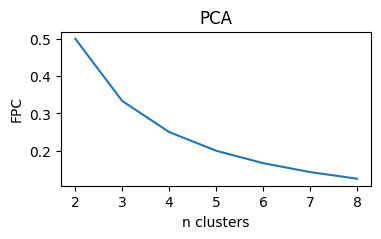

In [93]:
evaluar_fuzzy(X=Xpca, m=2, k_list=[2, 3, 4, 5, 6, 7, 8], title="PCA")

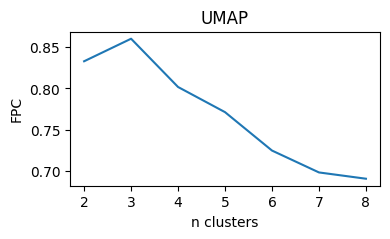

In [92]:
evaluar_fuzzy(Xumap, m=2, k_list=[2, 3, 4, 5, 6, 7, 8], title="UMAP")

In [8]:
fuzzy_params = {'n_clusters': 5, 'm':2}

pca_fz_labels = obtener_fuzzy_clusters(Xpca, fuzzy_params=fuzzy_params)

ct, rand, arand, vandon = cross_tab(Labels_orig=true_labels, Labels_clust=pca_fz_labels)

Fuzzy Clustering already finish, with FPC: 0.2000000000843144
RAND score=0.6509, Ajusted RAND=0.3017, vanDongen=0.5312 cantidad_de_muestras=60,000


In [9]:
ct

Labels_orig,Arborio,Basmati,Ipsala,Jasmine,Karacadag
Labels_clust,,,,,
0,1797,12005,2015,11662,1
2,78,0,100,4,0
3,14,0,9,0,0
4,10114,0,9793,338,12070


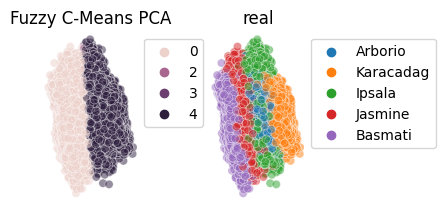

In [53]:
grafico_evaluacion(Xpca, true_labels, pca_fz_labels , nom_test='Fuzzy C-Means PCA')

In [105]:

fuzzy_params = {'n_clusters': 5, 'm':2}

umap_fz_labels = obtener_fuzzy_clusters(Xumap, fuzzy_params=fuzzy_params)

ct3, rand, arand, vandon = cross_tab(Labels_orig=true_labels, Labels_clust=umap_fz_labels)

Fuzzy Clustering already finish, with FPC: 0.7518526659566934
RAND score=0.9717, Ajusted RAND=0.9116, vanDongen=0.0462 cantidad_de_muestras=15,000


In [98]:
ct3

Labels_orig,Arborio,Basmati,Ipsala,Jasmine,Karacadag
Labels_clust,,,,,
0,57,235,42,11788,1
1,0,11770,1,121,0
2,3,0,11745,46,0
3,11631,0,121,45,167
4,312,0,8,4,11903


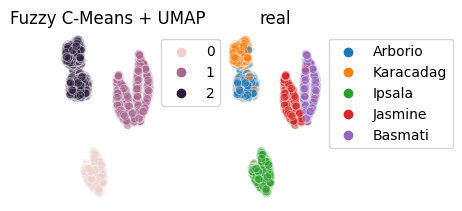

In [83]:
grafico_evaluacion(Xumap, true_labels, umap_fz_labels, nom_test = "Fuzzy C-Means + UMAP")